In [46]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np
import math
import matplotlib.pyplot as plt
spark2 =SparkSession.builder \
  .master('local[*]') \
  .appName('conversions') \
  .config('spark.jars.packages', 'com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.23.2') \
  .getOrCreate() 
sqlContext = SQLContext(spark2)

In [47]:
table_df = (spark2.read.format('bigquery').option('table', 'Top250_nftdata.etl_output')
                        .load())

In [48]:
table_df.show(5)
table_df.printSchema()

+--------------------+----------+-------+------------+-------+---------------+
|         Collections|SalesinUSD| Buyers|Transactions| Owners|Hundredmillclub|
+--------------------+----------+-------+------------+-------+---------------+
|       Axie Infinity|3328148500|1079811|     9755511|2656431|            Yes|
|         CryptoPunks|1664246968|   4723|       18961|   3289|            Yes|
|          Art Blocks|1075223906|  20934|      117602|  25094|            Yes|
|Bored Ape Yacht Club| 783882186|   8284|       22584|   5862|            Yes|
|        NBA Top Shot| 781965423| 374818|    11790699| 603928|            Yes|
+--------------------+----------+-------+------------+-------+---------------+
only showing top 5 rows

root
 |-- Collections: string (nullable = true)
 |-- SalesinUSD: long (nullable = false)
 |-- Buyers: long (nullable = false)
 |-- Transactions: long (nullable = false)
 |-- Owners: long (nullable = false)
 |-- Hundredmillclub: string (nullable = false)



In [49]:
bored_collection = table_df.filter(table_df.Collections.contains("Bored"))

sum_sales = bored_collection.select(sum('SalesinUSD')).collect()[0][0]
print(f"Total Sales of 'Bored Ape' Collection is ${sum_sales:,}")
bored_collection.show()


Total Sales of 'Bored Ape' Collection is $982,841,231
+--------------------+----------+------+------------+------+---------------+
|         Collections|SalesinUSD|Buyers|Transactions|Owners|Hundredmillclub|
+--------------------+----------+------+------------+------+---------------+
|Bored Ape Yacht Club| 783882186|  8284|       22584|  5862|            Yes|
|Bored Ape Kennel ...| 108210267|  5622|       13715|  5013|            Yes|
|Bored Ape Chemist...|  79456705|  1454|        2508|     1|             No|
|Bored Mummy Wakin...|  11292073|  6030|       14816|  3682|             No|
+--------------------+----------+------+------------+------+---------------+



+-----------+
|sum(Owners)|
+-----------+
|       3683|
|      10875|
+-----------+



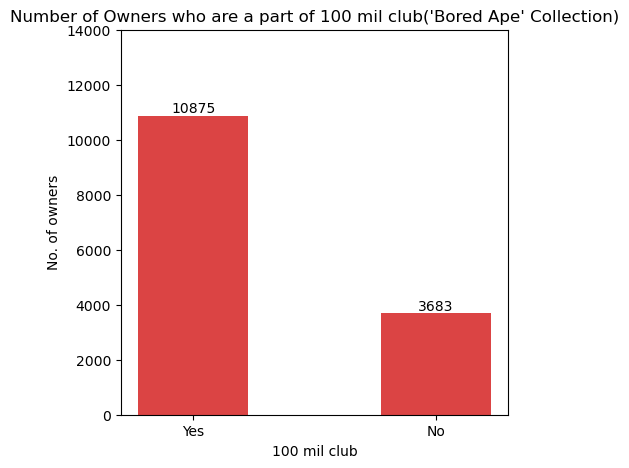

In [50]:
df2 = bored_collection.groupby('Hundredmillclub').sum()
df2.select('sum(Owners)').show()

owners = [df2.select('sum(Owners)').collect()[1][0],df2.select('sum(Owners)').collect()[0][0]]
con = ['Yes','No']
plt.style.use('default')
plt.figure(figsize=(5,5))
p =plt.bar(con,owners,width=0.45,color='#db4444')
plt.ylim(0,14000)
plt.title("Number of Owners who are a part of 100 mil club('Bored Ape' Collection)")
plt.bar_label(p)
plt.xlabel('100 mil club')
plt.ylabel('No. of owners')
plt.show()


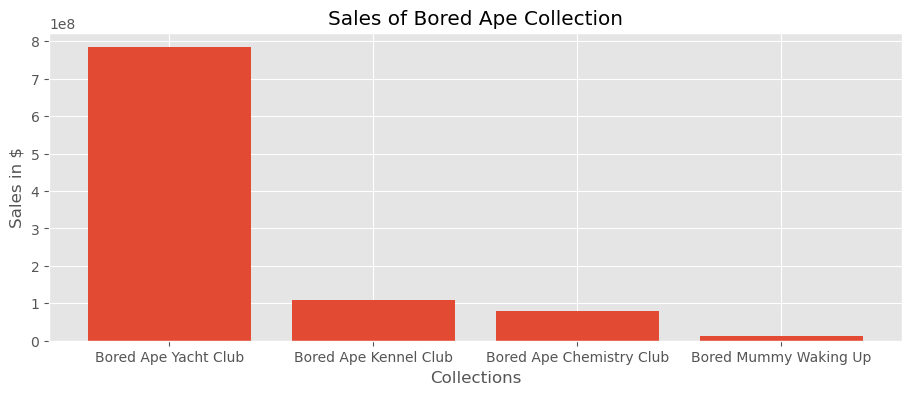

In [51]:
collection = bored_collection.select('Collections').toPandas()['Collections']
sales = bored_collection.select('SalesinUSD').toPandas()['SalesinUSD']
plt.style.use('ggplot')
plt.figure(figsize=(11,4))
plt.bar(collection,sales)
plt.title('Sales of Bored Ape Collection')
plt.xlabel('Collections')
plt.ylabel('Sales in $')
plt.show()

Average sales of 100 million club is 445,668,302.7916667$


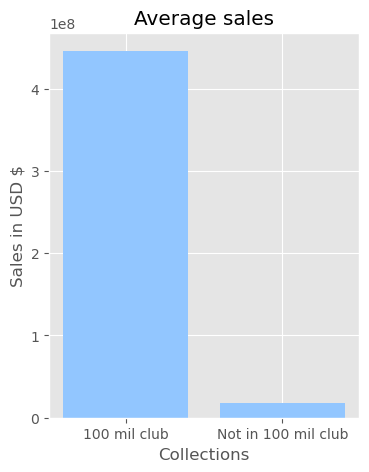

In [52]:
df_100mil = table_df.filter(table_df.Hundredmillclub == "Yes")
avg_sales_100mil = df_100mil.select(mean("SalesinUSD")).collect()[0][0]
df_non100mil = table_df.filter(table_df.Hundredmillclub == "No")
avg_sales_non100mil = df_non100mil.select(mean("SalesinUSD")).collect()[0][0]
print(f'Average sales of 100 million club is {avg_sales_100mil:,}$')

x= ['100 mil club','Not in 100 mil club']
avg = [avg_sales_100mil,avg_sales_non100mil]

plt.style.use('seaborn-pastel')
plt.figure(figsize=(4,5))

plt.bar(x,avg)
plt.title('Average sales')
plt.xlabel('Collections')
plt.ylabel('Sales in USD $')
plt.show()

DOES MORE NUMBER OF TRANSACTION PROVE MORE SALES? LET'S FIND OUT..
--

NBA Top Shot has 11790699 transactions (Highest amongst all)
CryptoPunks has 18961 transactions (Relatively lower transaction)


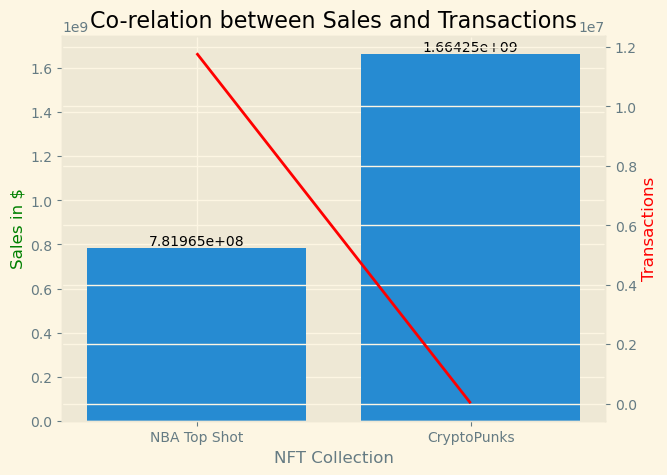

In [53]:
most_transaction = table_df.agg({"Transactions": "max"}).collect()[0][0]
most_data = table_df.filter(table_df.Transactions == most_transaction)
collection_of_most = most_data.select('Collections').collect()[0][0]
sales_of_most = most_data.select('SalesinUSD').collect()[0][0]

lower_transact = table_df.collect()[1][3]
collection_of_lower = table_df.collect()[1][0]
sales_of_lower = table_df.collect()[1][1]
print(f'{collection_of_most} has {most_transaction} transactions (Highest amongst all)')
print(f'{collection_of_lower} has {lower_transact} transactions (Relatively lower transaction)')

# #LET'S VISUALIZE THIS USING GRAPHS
collections = [collection_of_most,collection_of_lower]
sales = [sales_of_most,sales_of_lower]
transactions = [most_transaction,lower_transact]

plt.style.use('Solarize_Light2')
fig,ax1 = plt.subplots(figsize=(7,5))
ax2=ax1.twinx()
p = ax1.bar(collections,sales)
ax2.plot(collections,transactions,'r-')
ax1.bar_label(p)
plt.title('Co-relation between Sales and Transactions')
ax1.set_xlabel('NFT Collection')
ax1.set_ylabel('Sales in $',color='g')
ax2.set_ylabel('Transactions',color='r')
plt.show()
